In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

In [2]:
import mloop.interfaces as mli
import mloop.controllers as mlc
import mloop.visualizations as mlv

In [3]:
import os
import shutil
import time
import configparser

In [4]:
np.random.seed(42)

Vamos começar fazendo um gerador de pontos ao longo da curva de carga, com ruído. Vamos utilizar a curva de carga vista na tese para comparação.

In [5]:
class MOT():
    
    def __init__(self,L,g,b,w):
        self.loading_rate = L
        self.gamma = g
        self.b = b
        self.gaussian_width = w
        self.measurement_times = np.array([])
        self.measurements = np.array([])
        self.noisy_measurements = np.array([])
        
    def _a(self):
        return self.gamma
    
    def _b(self):
        return self.b
    
    def N(self,t):
        a = self._a()
        b = self._b()
        D = np.sqrt(a**2 + 4*self.loading_rate*b)
        return D/(2*b)*np.tanh(D*t/2 + np.arctanh(a/D)) - a/(2*b)
    
    def load_MOT(self,dt,endtime):
        self.measurement_times = np.arange(0,endtime,dt)
        self.measurements = np.array([[t,self.N(t)] for t in self.measurement_times])
        return None
    
    def measure_loading(self):
        nom = len(self.measurements)
        self.noise = np.array([[0,(np.random.random()-0.5)*(10e-3*np.random.random())] for i in list(range(nom))])
        self.noisy_measurements = self.measurements + self.noise
        return None
                            
    def return_loading_curve(self):
        plt.scatter(self.noisy_measurements[:,0],self.noisy_measurements[:,1],s=10,alpha=0.1)
        return self.noisy_measurements

Vamos definir nosso primeiro experimento, MOT1

In [6]:
MOT1 = MOT(0.20,0.72,0.074,0.082)

In [7]:
MOT1.load_MOT(0.005,10)

~10ksample (1-0.5ms)

In [8]:
MOT1.measure_loading()

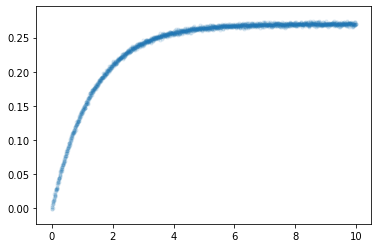

In [9]:
loading_curve = MOT1.return_loading_curve()
plt.show()

## Obtenção dos parâmetros

A obtenção dos parâmetros é feita em estágios, a partir da análise feita da solução analítica. Os parâmetros L e gamma podem ser obtidos a partir das duas soluções aproximadas  

$$\begin{align}
N_1(t) = Lt && N_2(t) = \frac{L}{\gamma}\left(1-e^{-\gamma t}\right)
\end{align}$$

Os tempos $t_1$ e $t_2$ definem a região de confiança para cada uma das soluções

In [10]:
t1 = 0.3
t2 = 0.8

In [11]:
def n1(t,L):
    return L*t

def n2(t,L,g):
    return (L/g)*(1-np.exp(-g*t))

Separamos os pontos que podem ser utilizados nos ajustes com cada solução.

In [12]:
data_point = 1
n1_fitting_data = np.array([loading_curve[0]])
while loading_curve[data_point,0] <= t1:
    n1_fitting_data = np.append(n1_fitting_data,[loading_curve[data_point]],axis=0)
    data_point += 1

In [13]:
np.array([loading_curve[0]])

array([[ 0.        , -0.00119277]])

In [14]:
data_point = 1
n2_fitting_data = np.array([loading_curve[0]])
while loading_curve[data_point,0] <= t2:
    n2_fitting_data = np.append(n2_fitting_data,[loading_curve[data_point]],axis=0)
    data_point += 1

Os ajustes são feitos com facilidade utilizando a função ```optimize.curve``` do SciPy.

[0.18495676] [[2.0500297e-06]]


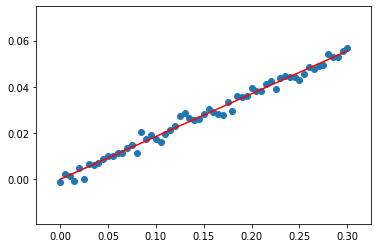

In [15]:
n1params, n1paramscov = optimize.curve_fit(n1, n1_fitting_data[:,0], n1_fitting_data[:,1])
plt.scatter(n1_fitting_data[:,0], n1_fitting_data[:,1])
plt.plot(n1_fitting_data[:,0],n1(n1_fitting_data[:,0],n1params[0]),c='red')
print(n1params,n1paramscov)

|Parâmetro | Valores reais | Valores ajustados |
|:---:|:---:|:---:|
| $L$ | 0.08 | 0.07427571 |

In [16]:
fit1L = n1params[0]

Utilizamos este valor de L para determinar gamma com o fitting de n2.

[0.18495676] [0.45342609]


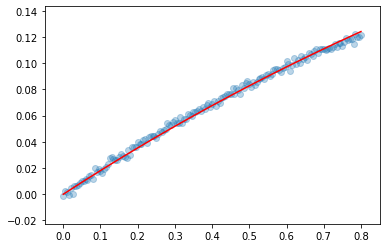

In [17]:
L_n2 = lambda t, g: n2(t, fit1L, g)
n2params, n2paramscov = optimize.curve_fit(L_n2, n2_fitting_data[:,0], n2_fitting_data[:,1])
plt.scatter(n2_fitting_data[:,0], n2_fitting_data[:,1],alpha=0.3)
plt.plot(n2_fitting_data[:,0],n2(n2_fitting_data[:,0],fit1L,n2params[0]),c='red')
print(n1params,n2params)

|Parâmetro | Valores reais | Valores ajustados |
|:---:|:---:|:---:|
| $L$ | 0.08 | 0.07427571 |
| $\gamma$ | 0.54 | 0.30022631|

In [18]:
first_optmization_results = [n1params[0],n2params[0]]

Os valores encontrados estão bem próximos dos reais, mas ainda apresentam diferenças consideráveis, em particular o de gamma, que carrega também o erro do L já fixado. Entretanto, devemos lembrar que esses valores foram obtidos sem oferecer qualquer tipo de chute inicial ao ```curve_fit```. Naturalmente, poderíamos ao menos lhe oferecer a ordem de grandeza esperada. Mas, imaginando um caso em que queremos restringir a otimização ao mínimo, podemos usar esses valores ajustados individualmente como chute inicial para uma otimização simultânea que deve fazer uma aproximação final.

array([0.19965352, 0.71195271])

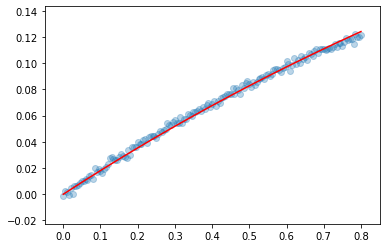

In [19]:
fit2Lg, fit2Lg_cov = optimize.curve_fit(n2, n2_fitting_data[:,0], n2_fitting_data[:,1],p0=first_optmization_results)
plt.scatter(n2_fitting_data[:,0], n2_fitting_data[:,1],alpha=0.3)
plt.plot(n2_fitting_data[:,0],n2(n2_fitting_data[:,0],fit1L,n2params[0]),c='red')
fit2Lg

| Valores reais | Valores ajustados |
|---|---|
| 0.08 | 0.0792766 |
| 0.54 | 0.51442491 |

Como esperados, obtemos uma medida ainda melhor. Táticas diferentes podem continuar a serem testadas em busca de maior precisão, mas este processo é suficiente por hora.

Tratando do caso homonuclear, o único parâmetro que resta a ser determinado é $\beta$. Para isso, fazemos um ajuste com a solução completa, e podemos ainda repetir a estratégia de fazer um ajuste coletivo após o ajuste individual.

In [20]:
def n3(t,L,g,beta):
    w=0.096
    a=g
    b=beta
    D = np.sqrt(a**2 + 4*L*b)
    return D/(2*b)*np.tanh(D*t/2 + np.arctanh(a/D)) - a/(2*b)

A solução completa $n_3$ exige um quarto parâmetro $w$. $w$ é a cintura gaussiana, uma característica geométrica da armadilha, que é medida diretamente. Como medida experimental, ela naturalmente inclui seu próprio erro, mas como não estamos simulando aqui o perfil de densidade do gás frio de onde se origina essa medida, iremos simplesmente utilizar o valor exato que entro na geração dos pontos.

In [21]:
n3_fitting_data = loading_curve[:]

[0.19965352 0.71195271] [0.10021625]


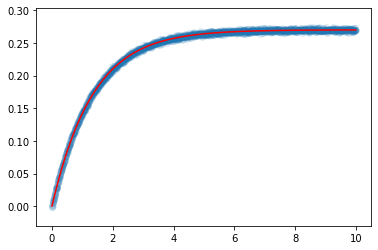

In [22]:
Lg_n3 = lambda t, b: n3(t, fit2Lg[0], fit2Lg[1], b)
n3params, n3paramscov = optimize.curve_fit(Lg_n3, n3_fitting_data[:,0], n3_fitting_data[:,1],p0=0.01)
plt.scatter(n3_fitting_data[:,0], n3_fitting_data[:,1],alpha=0.1)
plt.plot(n3_fitting_data[:,0],n3(n3_fitting_data[:,0],fit2Lg[0],fit2Lg[1],n3params),c='red')
print(fit2Lg,n3params)

In [23]:
second_optimization_results = [fit2Lg[1],n3params[0]]
second_optimization_results

[0.7119527062643086, 0.10021625482979564]

[0.71774691 0.07752437]


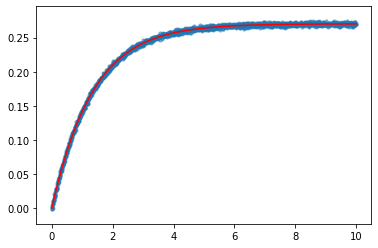

In [24]:
L_n3 = lambda t, g, b: n3(t, fit2Lg[0], g, b)
fit3Lgbeta, fit3Lgbeta_cov = optimize.curve_fit(L_n3, n3_fitting_data[:,0], n3_fitting_data[:,1],p0=second_optimization_results)
plt.scatter(n3_fitting_data[:,0], n3_fitting_data[:,1],alpha=0.5,s=10)
plt.plot(n3_fitting_data[:,0],n3(n3_fitting_data[:,0],fit2Lg[0],fit3Lgbeta[0],fit3Lgbeta[1]),c='red')
print(fit3Lgbeta)

In [25]:
third_optimization_results = [fit3Lgbeta[1]]

[0.07752437]


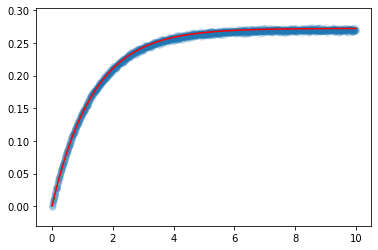

In [26]:
Lg_n3 = lambda t, b: n3(t, fit2Lg[0], fit3Lgbeta[0], b)
n3params, n3paramscov = optimize.curve_fit(Lg_n3, n3_fitting_data[:,0], n3_fitting_data[:,1],p0=third_optimization_results)
plt.scatter(n3_fitting_data[:,0], n3_fitting_data[:,1],alpha=0.1)
plt.plot(n3_fitting_data[:,0],n3(n3_fitting_data[:,0],fit2Lg[0],fit2Lg[1],n3params),c='red')
print(n3params)

#### Manipulação do arquivo .ini

Agora vamos utilizar o pacote ```ConfigParser``` para modificar o arquivo ```params.ini```, que contém as configurações da execução do experimento para o software de controle. O pacote utilizado torna essa interação tão simples quanto lidar com um dicionário normal do Python.

Primeiro criamos uma instância da classe ```ConfigParser```, que faz a interação com o arquivo.

In [27]:
config = configparser.ConfigParser()

In [28]:
config.read('params_example.ini')

['params_example.ini']

Com o arquivo aberto, podemos ver as seções que ele contém.

In [29]:
config.sections()

['MOT',
 'SEQ',
 'RAMPSAFTERMOT',
 'CNC_BEC1',
 'MOLASSES',
 'OPTICALPUMPING',
 'OPTICALPUMPING_F1',
 'CATCH',
 'QUADRUPOLERAMP',
 'QUADRUPOLE_RELAX',
 'OT_EVAPORATION_F2',
 'OT_EVAPORATION_F1',
 'QUIC_EVAPORATION',
 'EXCITATION',
 'EXCITATION2',
 'EXCITATION_SUMSINES',
 'BIAS_INVERSION',
 'TOF',
 'IMAGING',
 'IMAGING_sting',
 'MOTRECAPTURE',
 'DPPulse',
 'QUICHold',
 'STERNGERLACH',
 'TASK',
 'BOOL',
 'MEASUREMENTSRESULTS']

Ou visualizar os parâmetros em alguma seção em particular.

In [30]:
for key in config['MOT']:
    print(key)

goal
coilscurrent
coolingfrequency
zcompensation
pushfrequency
delayleds
mottof


Ou ver o valor de cada parâmetro.

In [31]:
for key in config['MOT']:
    print(key,'=',config['MOT'][key])

goal = 11.0
coilscurrent = 0.09
coolingfrequency = 1.15
zcompensation = 0.4
pushfrequency = 2.6
delayleds = 12.0
mottof = 1000.0


A edição de um valor é feita simplesmente por

In [32]:
config['MOT']['goal'] = '10.0'
for key in config['MOT']:
    print(key,'=',config['MOT'][key])

goal = 10.0
coilscurrent = 0.09
coolingfrequency = 1.15
zcompensation = 0.4
pushfrequency = 2.6
delayleds = 12.0
mottof = 1000.0


O mesmo é feito para adicionar um novo parâmetro.

In [33]:
config['MOT']['goal2'] = '11.0'
for key in config['MOT']:
    print(key,'=',config['MOT'][key])

goal = 10.0
coilscurrent = 0.09
coolingfrequency = 1.15
zcompensation = 0.4
pushfrequency = 2.6
delayleds = 12.0
mottof = 1000.0
goal2 = 11.0


E para remover um valor

In [34]:
config.remove_option('MOT','goal2')
for key in config['MOT']:
    print(key,'=',config['MOT'][key])

goal = 10.0
coilscurrent = 0.09
coolingfrequency = 1.15
zcompensation = 0.4
pushfrequency = 2.6
delayleds = 12.0
mottof = 1000.0


A estrutura simples do pacote torna sua implementação simples e rápida ao lado do MLOOP, como na próxima seção.

#### Leitura da curva a partir de arquivo .txt

Primeiro abrimos o rquivo de texto em modo de leitura.

In [35]:
shutil.copyfile('MOT1pdbak.txt', 'MOT1pd.txt')

'MOT1pd.txt'

In [36]:
curve = open('MOT1pd.txt','r')

A primeira linha do arquivo simplesmente nomeia as colunas. Criamos um array cujos elementos são as linhas (ainda strings) do .txt, excluindo a primeira.

In [37]:
curvelines = curve.readlines()[1:]
print(curvelines[:5])

['100\t0.145575\n', '105\t0.152602\n', '110\t0.16195\n', '115\t0.187029\n', '120\t0.183161\n']


Inicializamos uma matriz (np.array) vazia para receber a devidamente formatada (isto é, num formato diretamente utilizável para cálculos).

In [38]:
l_curve = np.empty([0,2])

Agora preenchemos essa matriz com as linhas do arquivos, reorgarnizadas como arrays de números.

In [39]:
for line in curvelines:
    formatted_line = np.array([np.float64([line.split('\t')[0],line.split('\t')[1][:-2]])])
    l_curve = np.concatenate((l_curve,formatted_line))

Por último, subtraímos da curva seu deslocamento a partir do zero. Naturalmente, a população inicial deve ser $0$, de modo que podemos razoávelmente exigir que $N(0)=0$, e considerar qualquer desvio como ruído. Entretanto, notamos que neste conjunto de dados o ponto $N(0)$ tem um valor em torno de $0.01$ maior que os primeiros pontos após ele. Seria simples aqui descartar esse único ponto dentre centenas e seguir a análise. Entretanto, queremos um código que seja capaz de lidar com *qualquer* conjunto de dados, e não podemos prever quantos pontos iniciais (talvez nenhum) devem ser excluidos. Seria simples inserir uma função que fizesse esssa determinação de modo adequado, mas não o faremos ainda nesta primeira versão do código. Por hora, redefinimos o $N=0$ a partir do menor valor de $N$ na lista, quer seja o primeiro ou não.

In [40]:
l_curve -= np.array([[100*np.float64(15.03/1320),min(l_curve[:,1])]]*len(l_curve))

#### Visualização

As curvas de carga são recebidas como pontos (número da medição,tensão). "Número da medição" é apenas um número designado a cada ponto pelo software do laboratório em intervalos regulares. A conversão ao instante real da medida a partir do primeiro ponto é feita simplesmente registrando-se o tempo total de carregamento e dividindo pelo maior número de medição (esse tempo deverá ser passado automaticamente de alguma forma ao otimizador). Na curva de exemplo temos 

$$15.03/1320\approx 0.011$$

que nos diz quanto tempo se passa entre cada medição e é nosso fator de escala temporal, ```self._timescale```. Isso é tudo que deve ser feito antes do ajuste. Para a visualização, é mais instrutivo que a exibição do eixo vertical seja em número de átomos aprisionados, e não a tensão no fotodetector. Nesse caso, o fator de conversão ```self._popscale``` foi determinado na calibração do equipamento como

$$1.023\cdot10^8$$

e pode ser entendido com base na física do espalhamento por um átomo. O princípio do resfriamento está na troca de momento entre átomos e fótons: um átomo absorve um fóton, e depois de um tempo característico $\tau$ (tempo de vida do estado excitado), retorna ao estado fundamental por emissão espontânea de um fóton com mesma energia. Como a absorção sempre ocorre por fótons vindos da mesma direção e a emissão não tem direção preferencial, o efeito médio no tempo é de dar ao átomo momento na direção do laser. A ausência de direção preferencial de emissão implica que, em média no tempo, há uma radiação isotrópica de energia pelo átomo. Se cada fóton tem energia $h\nu$ e um fóton é emitido a cada intervalo $\tau$, a potência de radiação deverá ser 

$$P=\frac{h\nu}{\tau}$$

A potência de radiação por ângulo sólido é 

$$p=\frac{h\nu}{4\pi\tau}$$

Para determinar a potência recebida pelo fotodetector, basta determinar o ângulo sólido $\Omega_f$ coberto por este com base na geometria da armadilha. Adicionalmente, podemos considerar a transmitância $T_v$ do painel de vidro da armadilha que a luz cruza antes de chegar ao fotodetector. Nesse caso, a potência recebida pelo fotodetector para um átomo é 

$$P_f = \frac{h\Omega_f T_v\nu}{4\pi\tau}$$

Para uma população de N átomos, a potêncial total é 

$$P_f = \frac{hN\Omega_f T_v\nu}{4\pi\tau}$$

Cuja relação com a tensão gerada depende do fotodetector em si. Dessa forma é possível encontrar a relação entre a tensão medida e a quantidade de átomos na armadilha.

#### Implementação no M-LOOP

Todas as otimizações feitas agora devem ser feitas internamente pelo M-LOOP a partir dos pontos da curva de carga real medidos. O que se encontra abaixo é um código de exemplo, baseado naqueles já feitos anteriormente.

In [41]:
class MOTinterface(mli.Interface):
    """M-LOOP interface for a Python-controlled
    magneto-optical trap.
    
    Parameters
    ----------

    """
    
    def __init__(self,simultaneous_fitting):
        super(MOTinterface,self).__init__()
        self.loading_curve = np.empty([0,2])
        self._n1_trust_radius = np.float64(4.0)
        self._n2_trust_radius = np.float64(6.0)
        self._L = np.float64(1)
        self._g = np.float64(1)
        self._b = np.float64(1)
        self._cov_matrix = np.empty(1)
        self._L_cov = np.float64(1)
        self._g_cov = np.float64(1)
        self._b_cov = np.float64(1)
        self._trash_bin = 0
        self._timescale = np.float64(15.03/1320)
        self._ini_path = 'params.ini'
        self._data_path = 'MOT1pd.txt'
        self._settings = configparser.ConfigParser()
        self._simultaneous_fitting = simultaneous_fitting
        
    def n1(self,t,L):
        return L*t

    def n2(self,t,L,g):
        return (L/g)*(1-np.exp(-g*t))
    
    def n3(self,t,L,g,b):
        a = g
        D = np.sqrt(a**2 + 4*L*b)
        return D/(2*b)*np.tanh(D*t/2 + np.arctanh(a/D)) - a/(2*b)
    
    def _n1_fitting_data(self):
        data_point = 1
        n1_fitting_data = np.array([self.loading_curve[0]])
        while self.loading_curve[data_point,0] <= self._n1_trust_radius:
            n1_fitting_data = np.append(n1_fitting_data,[self.loading_curve[data_point]],axis=0)
            data_point += 1
        return n1_fitting_data
    
    def _n2_fitting_data(self):
        data_point = 1
        n2_fitting_data = np.array([self.loading_curve[0]])
        while self.loading_curve[data_point,0] <= self._n2_trust_radius:
            n2_fitting_data = np.append(n2_fitting_data,[self.loading_curve[data_point]],axis=0)
            data_point += 1
        return n2_fitting_data
    
    def _n3_fitting_data(self):
        return self.loading_curve

    def _n1_fitting(self):
        n1_fitting_data = self._n1_fitting_data()
        fitL, fitL_cov = optimize.curve_fit(self.n1, n1_fitting_data[:,0], n1_fitting_data[:,1])
        return fitL, fitL_cov
        
    def _n2_fitting(self,L=None):
        n2_fitting_data = self._n2_fitting_data()
        
        if L == None:
            n2 = lambda t, g: self.n2(t,self._L,g)
            fitLg, fitLg_cov = optimize.curve_fit(n2, n2_fitting_data[:,0], n2_fitting_data[:,1])
        
        else:
            fitLg, fitLg_cov = optimize.curve_fit(self.n2, n2_fitting_data[:,0], n2_fitting_data[:,1],p0=[self._L,self._g])
        
        return fitLg, fitLg_cov        
        
        
    def _n3_fitting(self,L=None,g=None):
        n3_fitting_data = self._n3_fitting_data()
            
        if g == None:
            n3 = lambda t, b: self.n3(t,self._L,self._g,b)
            fitLgB, fitLgB_cov = optimize.curve_fit(n3, n3_fitting_data[:,0], n3_fitting_data[:,1])
            
        else:
            n3 = lambda t, g, b: self.n3(t,self._L,g,b)
            fitLgB, fitLgB_cov = optimize.curve_fit(n3, n3_fitting_data[:,0], n3_fitting_data[:,1],p0=[self._g,self._b])
        
        return fitLgB, fitLgB_cov        
    
        
    def fitting_routine(self):
        """Executes a fitting routine over the three
        available solutions n1, n2 and n3. Fits each
        parameter individually, with collective fitting
        in between, using the latest fitted parameters 
        as initial guesses.
        
        Parameters
        ----------
        
        Returns
        -------
        """
        
        [self._L], self._cov_matrix = self._n1_fitting()
        self._L_cov = np.sqrt(np.diag(self._cov_matrix))
        print(self._L,self._g,self._b)
        
        [self._g], self._cov_matrix = self._n2_fitting()
        self._g_cov = np.sqrt(np.diag(self._cov_matrix))
        print(self._L,self._g,self._b)
        
        #See note below for why this is disabled
        #if self._simultaneous_fitting:
        #    [self._L,self._g], self._cov_matrix = self._n2_fitting(L=self._L)
        #    [self._L_cov,self._g_cov] = np.sqrt(np.diag(self._cov_matrix))
        #    print(self._L,self._g,self._b)
            
        [self._b], self._cov_matrix = self._n3_fitting()
        [self._b_cov] = np.sqrt(np.diag(self._cov_matrix))
        print(self._L,self._g,self._b)
        
        #This fits g and b simultaneously; Whenever it is active alongside
        #simultaneous fitting of L and g, it seems to cause b to be severely
        #underfitted, actually dropping up to four orders, causing the
        #standard deviation to actually become greater than the parameter
        #estimate itself. I've opted to leave this on enable and disable 
        #simultaneous optimization of L and g since L should be already well
        #fitted from the linear regime, and fitting L and g simultaneously
        #seems to cause b underfitting even when this one is disabled
        if self._simultaneous_fitting:
            [self._g,self._b], self._cov_matrix = self._n3_fitting(g=self._g)
            [self._g_cov,self._b_cov] = np.sqrt(np.diag(self._cov_matrix))
        print(self._L,self._g,self._b)
        
        self.fitting_plot()
        
        print(self._L,self._L_cov)
        print(self._g,self._g_cov)
        print(self._b,self._b_cov)
        
        return None
    
    def fitting_plot(self):
        plt.scatter(self.loading_curve[:,0],self.loading_curve[:,1],alpha=0.5)
        plt.plot(self.loading_curve[:,0], self.n3(self.loading_curve[:,0], self._L, self._g, self._b), c='red')
        plt.show()
            
        return None
        
        
    def get_next_cost_dict(self,params_dict):
        """Receives the latest set of optimized parameters
        from a dictionary, runs the experiment and updates
        a cost dictionary with the resulting cost, 
        uncertainty, if available, and with a "bad" label,
        if necessary.
        
        Parameters
        ----------
        params_dict : dictionary
            Holds as an a element a list of the best
            parameters from the most recent update of the
            internal model.
        
        Returns
        -------
        cost_dict : dictionary
            Holds elements for the cost and uncertainty
            values, plus the 'bad' flag. For bad runs, only
            the flag need be passed. Otherwise, the
            uncertainty remains optional.
        """
        params = params_dict['params']
        
        coolingfrequency = str(params[0])
        zcompensation = str(params[1])
        pushfrequency = str(params[2])
        
        self._settings.read(self._ini_path)
        
        self._settings['MOT']['coolingfrequency'] = coolingfrequency
        self._settings['MOT']['zcompensation'] = zcompensation
        self._settings['MOT']['pushfrequency'] = pushfrequency
        
        #at this point, the lab software has to somehow know that the
        #params.ini file has been updated and run the experiment. 
        #If there's anything that needs to be done on the M-LOOP side
        #for this to happen, this is where that would go.
        
        time.sleep(15)
        
        while not os.path.exists(self._data_path):
            pass
        
        curve = open(self._data_path,'r')
        curvelines = curve.readlines()[1:]
        curve.close()
        os.remove(self._data_path)
        
        for line in curvelines:
            formatted_line = np.array([np.float64([line.split('\t')[0],line.split('\t')[1][:-2]])])
            self.loading_curve = np.concatenate((self.loading_curve,formatted_line*[self._timescale,1]))
        self.loading_curve -= np.array([[100*self._timescale,min(self.loading_curve[:,1])]]*len(self.loading_curve))

        self.fitting_routine()
        
        cost = self._L
        uncer = 1e-3
        bad = False
    
        cost_dict = {'cost' : cost, 'uncer' : uncer, 'bad' : bad}

        return cost_dict 

Algumas observações devem ser feitas em relação ao código acima. Embora o grosso do trabalho tenha sido feito, ele ainda não é o código final. Certos detalhes dependem de como funcionará o lado do LabView:
* O nome do arquivo .txt que contém a curva está "hard-coded" script. Uma das necessidades será a de que o LabView salve automaticamente esse curva para que o programa possa lê-la. No modelo atual, esse arquivo é deletado após a leitura, e sempre tem o mesmo nome. Se o LabView salvar a curva de cada experimento separadamente, com um arquivo identificado pelo número de execução (run number), seria simples adicionar um contador ao código para que o M-LOOP pudesse ler o arquivo da execução correta a cada iteração. Estes arquivos podem ficar em qualquer pasta, é claro. Se estas pastas forem identificadas pela data/horário da realização do experimento, podemos utilizar a biblioteca ```datetime``` para obter a data e hora do sistema, a partir das quais podemos identificar corretamente a pasta onde as curvas de carga em questão estão armazenadas.
* O código também deve ser capaz de aguardar a execução do experimento antes de procurar a nova curva de carga. No momento, essa espera está implementada com pouco refinamento: há um período de espera de $15\,s$, que deve ser suficiente para qualquer curva, e então ocorre uma checagem da existência do arquivo antes do seu carregamento. A checagem ocorre de modo contínuo até que o arquivo apareça, caso ele já não esteja lá após os $15\,s$; essa checagem contínua tende a ser muito ineficiente no consumo de recursos do sistema, de modo que ficam para investigação futura modos mais eficientes (computacionalmente e em tempo) de aguardar a finalização da carga do MOT.

#### Teste do código com uma curva real

Fazemos abaixo a implementação padrão do controlador do M-LOOP com a interface construída na seção anterior. Uma descrição mais cuidadosa do funcionamento das componentes do M-LOOP está no arquivo ```GuiaMLOOP.ipynb```.

In [42]:
def main(simultaneous_fitting = True):
    """Creates an instance of the MOTinterface class, then
    a controller with that interface and a series of 
    configurations (that can be found in the M-LOOP 
    documentation). Lastly, the optimize() method is called
    to start the process."""
    interface = MOTinterface(simultaneous_fitting)
    controller = mlc.create_controller(interface,
                                       num_params = 3,
                                       min_boundary = [1,0.1,2],
                                       max_boundary = [2,1,3],
                                       first_params = [1.15,0.4,2.6],
                                       max_num_runs = 1,
                                       cost_has_noise = True,
                                       no_delay = False)
    controller.optimize()
    
    return controller

Note que os pontos utilizados aqui não incluem ainda erro.

In [43]:
shutil.copyfile('MOT1pdbak.txt', 'MOT1pd.txt')

'MOT1pd.txt'

INFO     Optimization started.
INFO     Run:1 (training)
INFO     params [1.15 0.4  2.6 ]
0.1228834939639932 1.0 1.0
0.1228834939639932 0.038063137837280096 1.0
0.1228834939639932 0.038063137837280096 0.033064024871355416
0.1228834939639932 0.025775533816964714 0.04915594199086493


/home/lucasdsa/anaconda3/envs/MLOOPcopy/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning:

invalid value encountered in sqrt



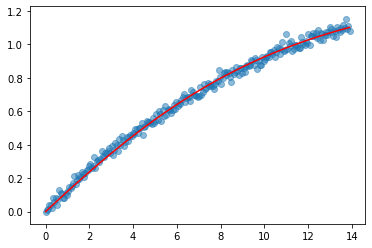

0.1228834939639932 [0.00118534]
0.025775533816964714 0.0030871064104821913
0.04915594199086493 0.004085817105282234
INFO     cost 0.1228834939639932 +/- 0.001
INFO     Controller finished. Closing down M-LOOP. Please wait a moment...
INFO     Optimization ended because:-
INFO     Maximum number of runs reached.
INFO     Results:-
INFO     Best parameters found:[1.15 0.4  2.6 ]
INFO     Best cost returned:0.1228834939639932 +/- 0.001
INFO     Best run number:1
INFO     Predicted best parameters:[1.15 0.4  2.6 ]
INFO     Predicted best cost:[0.12288349] +/- [0.00447214]
INFO     M-LOOP Done.


In [44]:
main()

In [113]:
shutil.copyfile('MOT1pdbak.txt', 'MOT1pd.txt')

'MOT1pd.txt'

INFO     Optimization started.
INFO     Run:1 (training)
INFO     params [1.15 0.4  2.6 ]
0.1228834939639932 1.0 1.0
0.1228834939639932 0.038063137837280096 1.0
0.1228834939639932 0.038063137837280096 0.033064024871355416


/home/lucasdsa/anaconda3/envs/MLOOPcopy/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning:

invalid value encountered in sqrt



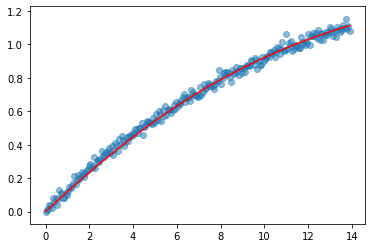

0.1228834939639932 [0.00118534]
0.038063137837280096 [0.00283336]
0.033064024871355416 0.0006757594145611178
INFO     cost 0.1228834939639932 +/- 0.001
INFO     Controller finished. Closing down M-LOOP. Please wait a moment...
INFO     Optimization ended because:-
INFO     Maximum number of runs reached.
INFO     Results:-
INFO     Best parameters found:[1.15 0.4  2.6 ]
INFO     Best cost returned:0.1228834939639932 +/- 0.001
INFO     Best run number:1
INFO     Predicted best parameters:[1.15 0.4  2.6 ]
INFO     Predicted best cost:[0.12288349] +/- [0.00447214]
INFO     M-LOOP Done.


In [114]:
main(False)

O próximo passo é testar o fucionamento do código com uma curva gerada a partir da solução de $N(t)$, onde podemos fazer a comparação do resultado com valores exatos de $L$, $a$ e $b$. Uma vez que esses resultados sejam satisfatórios, passamos ao uso de curvas reais, já com alguma confiança.